# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "ICA"

# Source Generation and Mixing Scenario

In [2]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(
    rho=0.0,
    df=4,
    n_sources=NumberofSources,
    size_sources=N,
    decreasing_correlation=True,
)
S = 2 * S - 1
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures, NumberofSources)
A =ortho_group.rvs(NumberofSources)
X = np.dot(A, S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.00066966587349


# Visualize Generated Sources and Mixtures

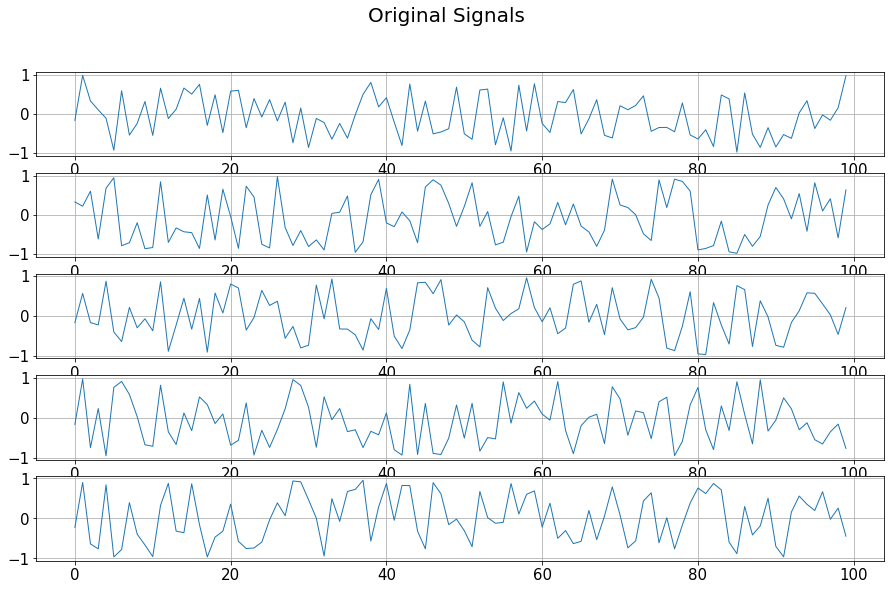

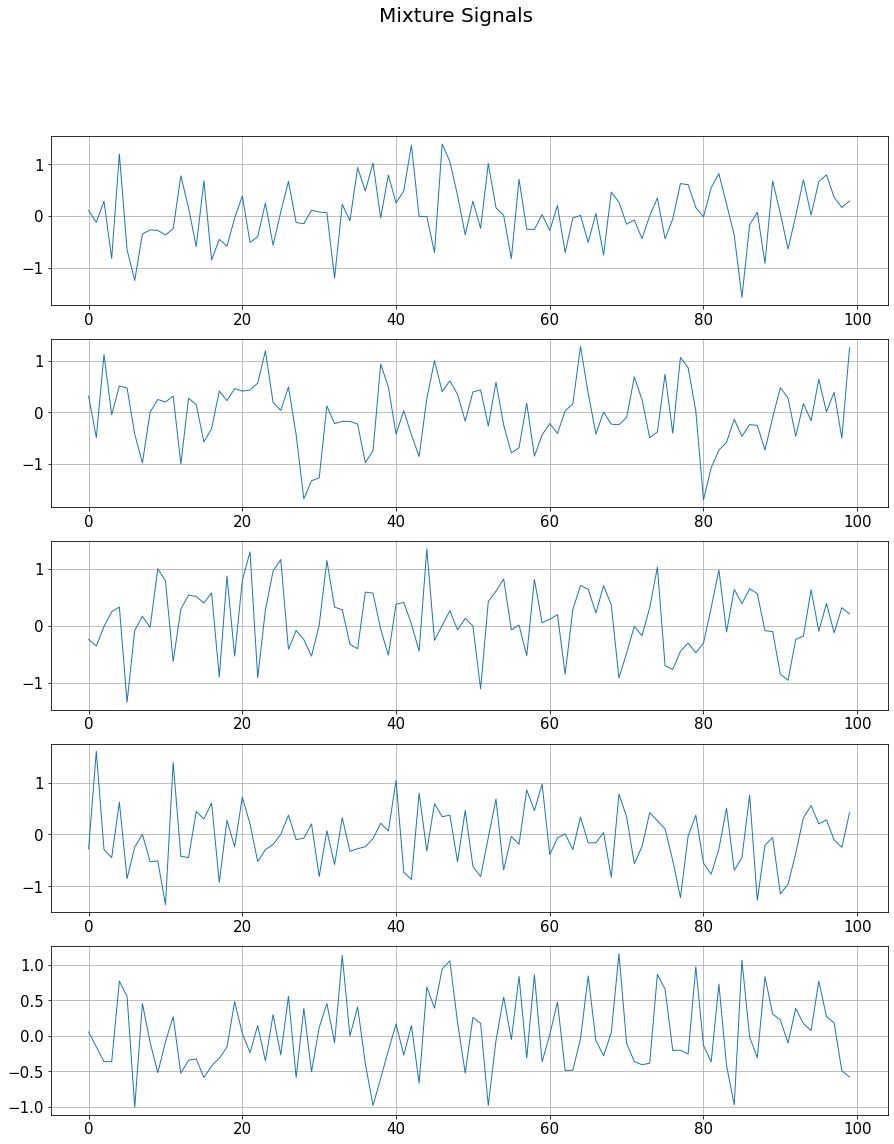

In [3]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
lambday = 1 - 1e-1 / 10
lambdae = 1 - 1e-1 / 10
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 1e3 * np.eye(s_dim)

debug_iteration_point = 25000
model = OnlineCorInfoMaxICA(
    s_dim=s_dim,
    x_dim=x_dim,
    muW=30 * 1e-3,
    lambday=lambday,
    lambdae=lambdae,
    By=By,
    Be=Be,
    neural_OUTPUT_COMP_TOL=1e-6,
    set_ground_truth=True,
    S=S,
    A=A,
)

# Run CorInfoMax Algorithm on Mixture Signals

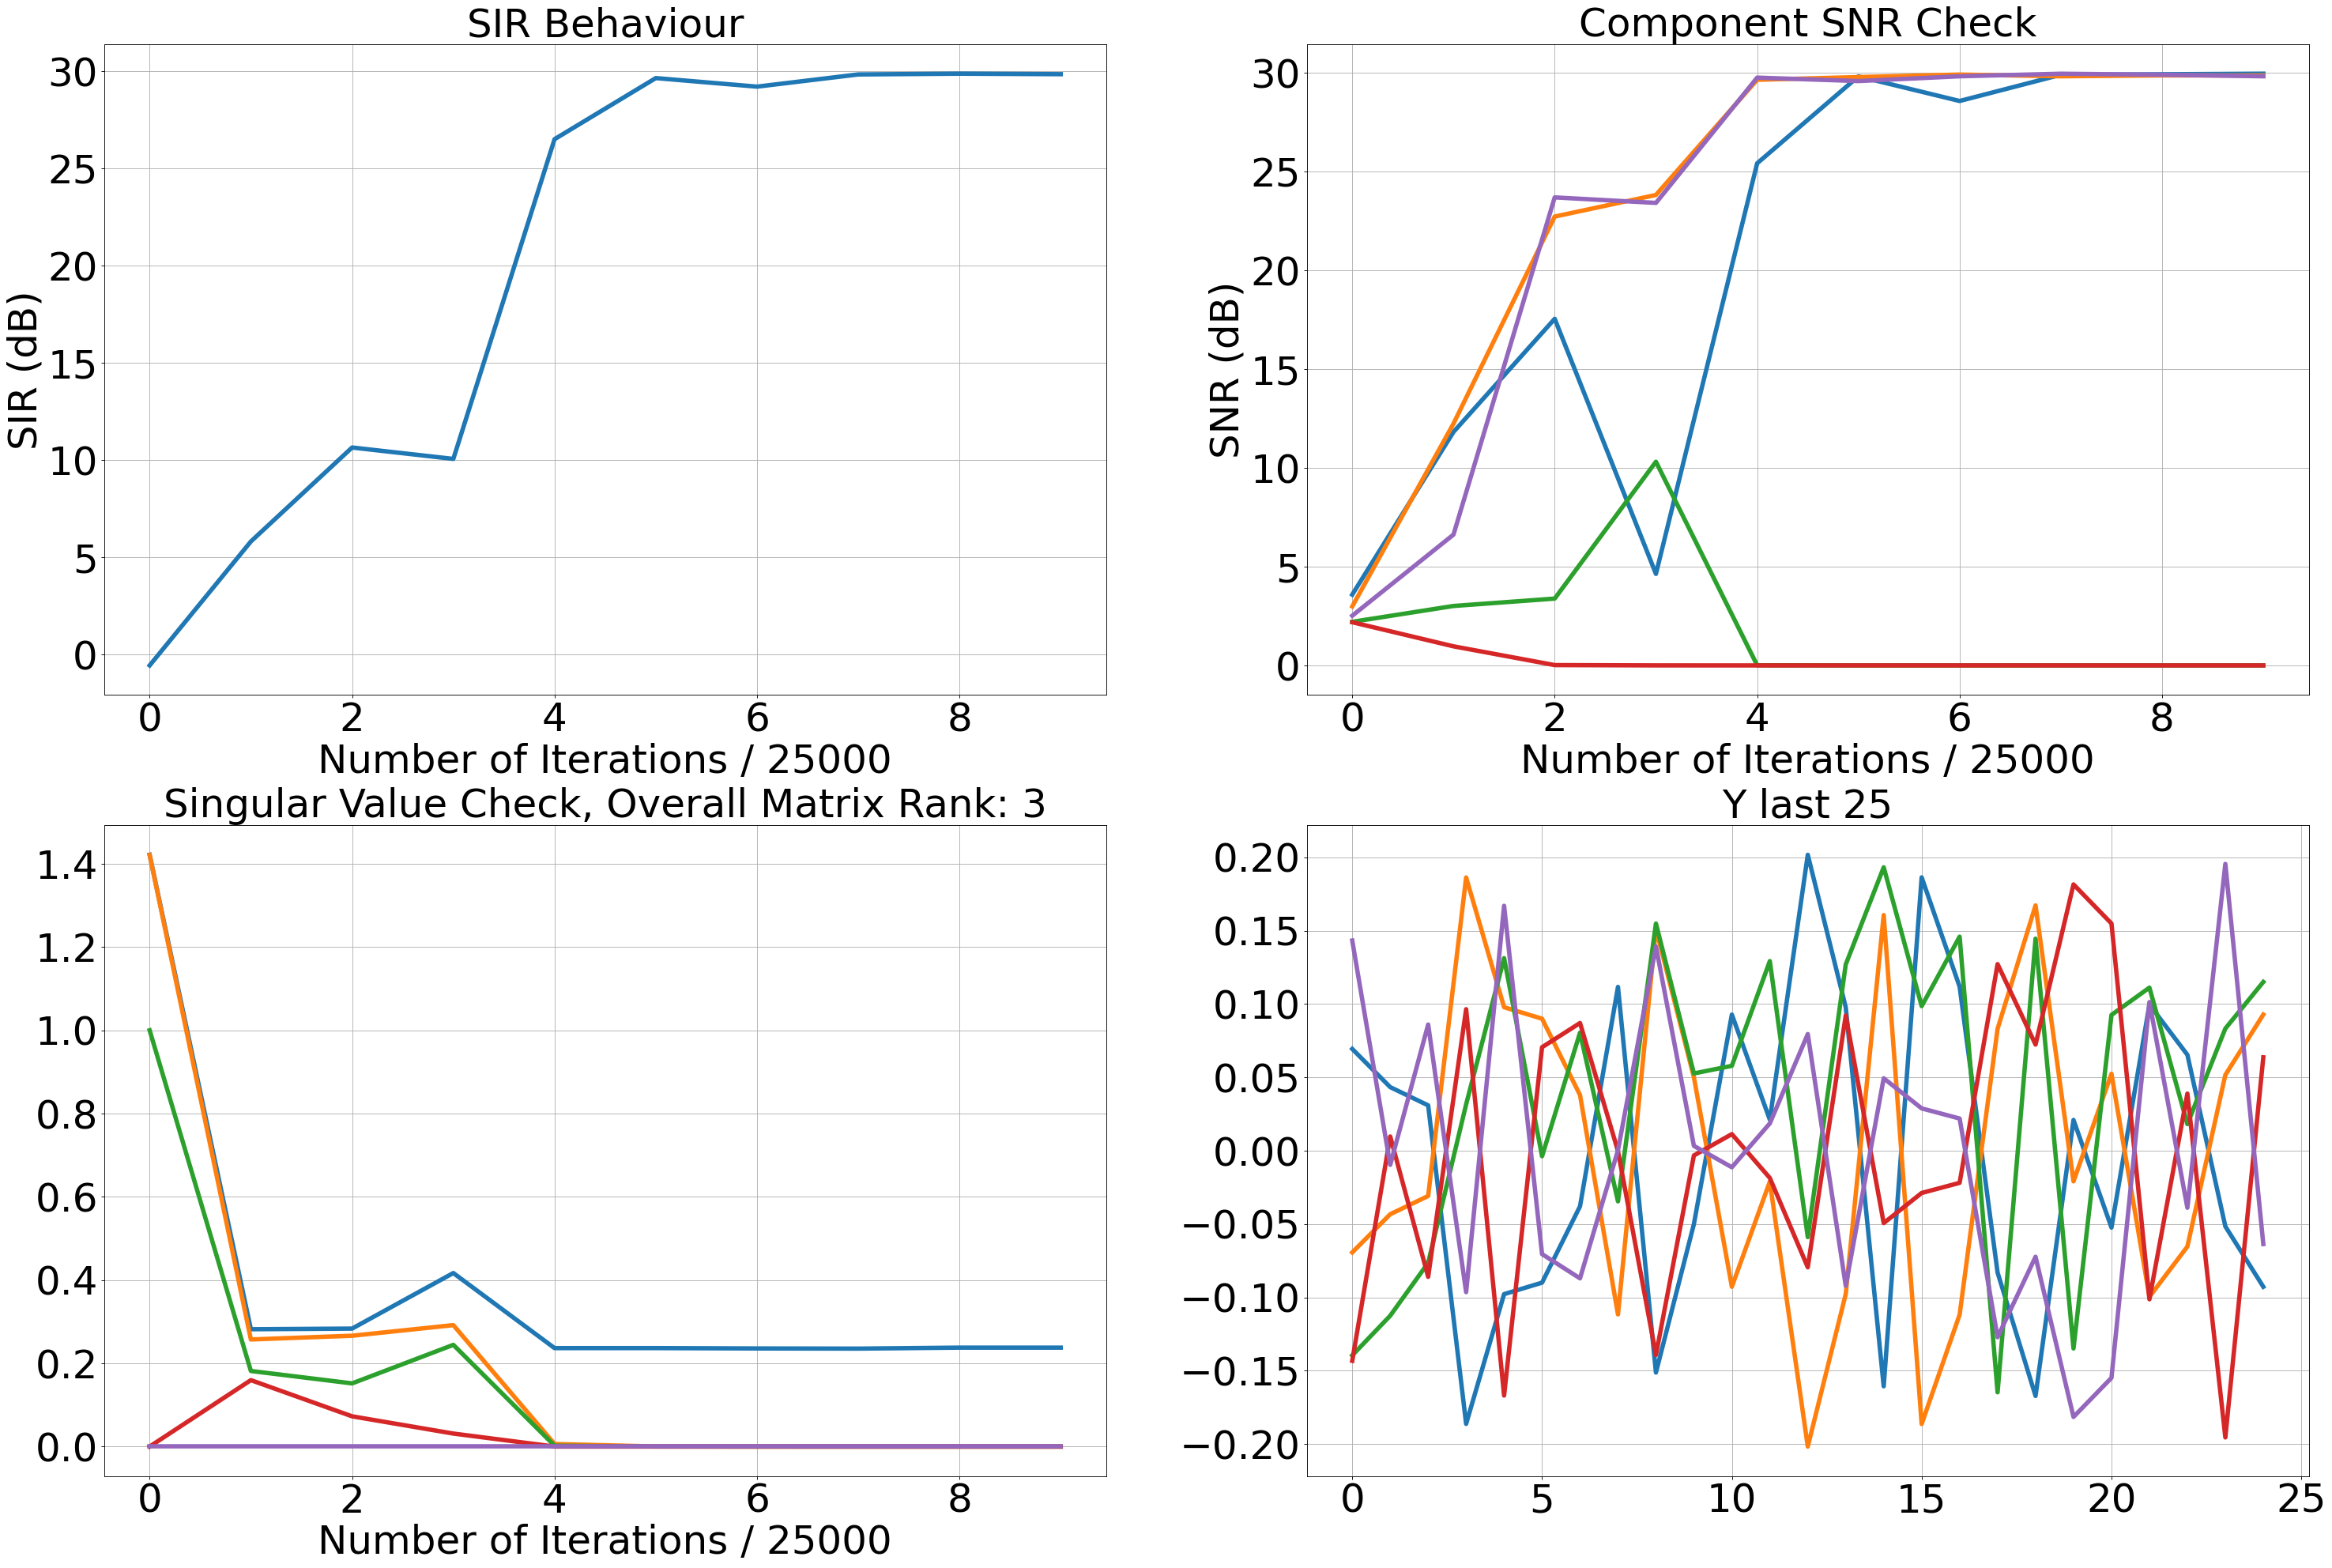

 50%|████▉     | 249408/500000 [01:01<00:15, 16396.90it/s]

SVD did not converge


 55%|█████▌    | 276010/500000 [01:09<01:44, 2142.29it/s] 

SVD did not converge


 61%|██████    | 302523/500000 [01:14<01:14, 2642.94it/s] 

SVD did not converge


 66%|██████▌   | 330399/500000 [01:17<00:32, 5184.25it/s] 

SVD did not converge


 70%|██████▉   | 349599/500000 [01:17<00:07, 20224.15it/s]

SVD did not converge


 76%|███████▌  | 380702/500000 [01:24<00:29, 4047.78it/s] 

SVD did not converge


 80%|███████▉  | 399842/500000 [01:24<00:06, 15658.19it/s]

SVD did not converge


 85%|████████▍ | 424762/500000 [01:31<00:05, 13995.07it/s]

SVD did not converge


 90%|█████████ | 452108/500000 [01:36<00:09, 4791.61it/s] 

SVD did not converge


 96%|█████████▌| 477606/500000 [01:41<00:12, 1821.04it/s] 

SVD did not converge


100%|██████████| 500000/500000 [01:48<00:00, 4617.04it/s] 

SVD did not converge
Algorithm took 108.512292 sec.


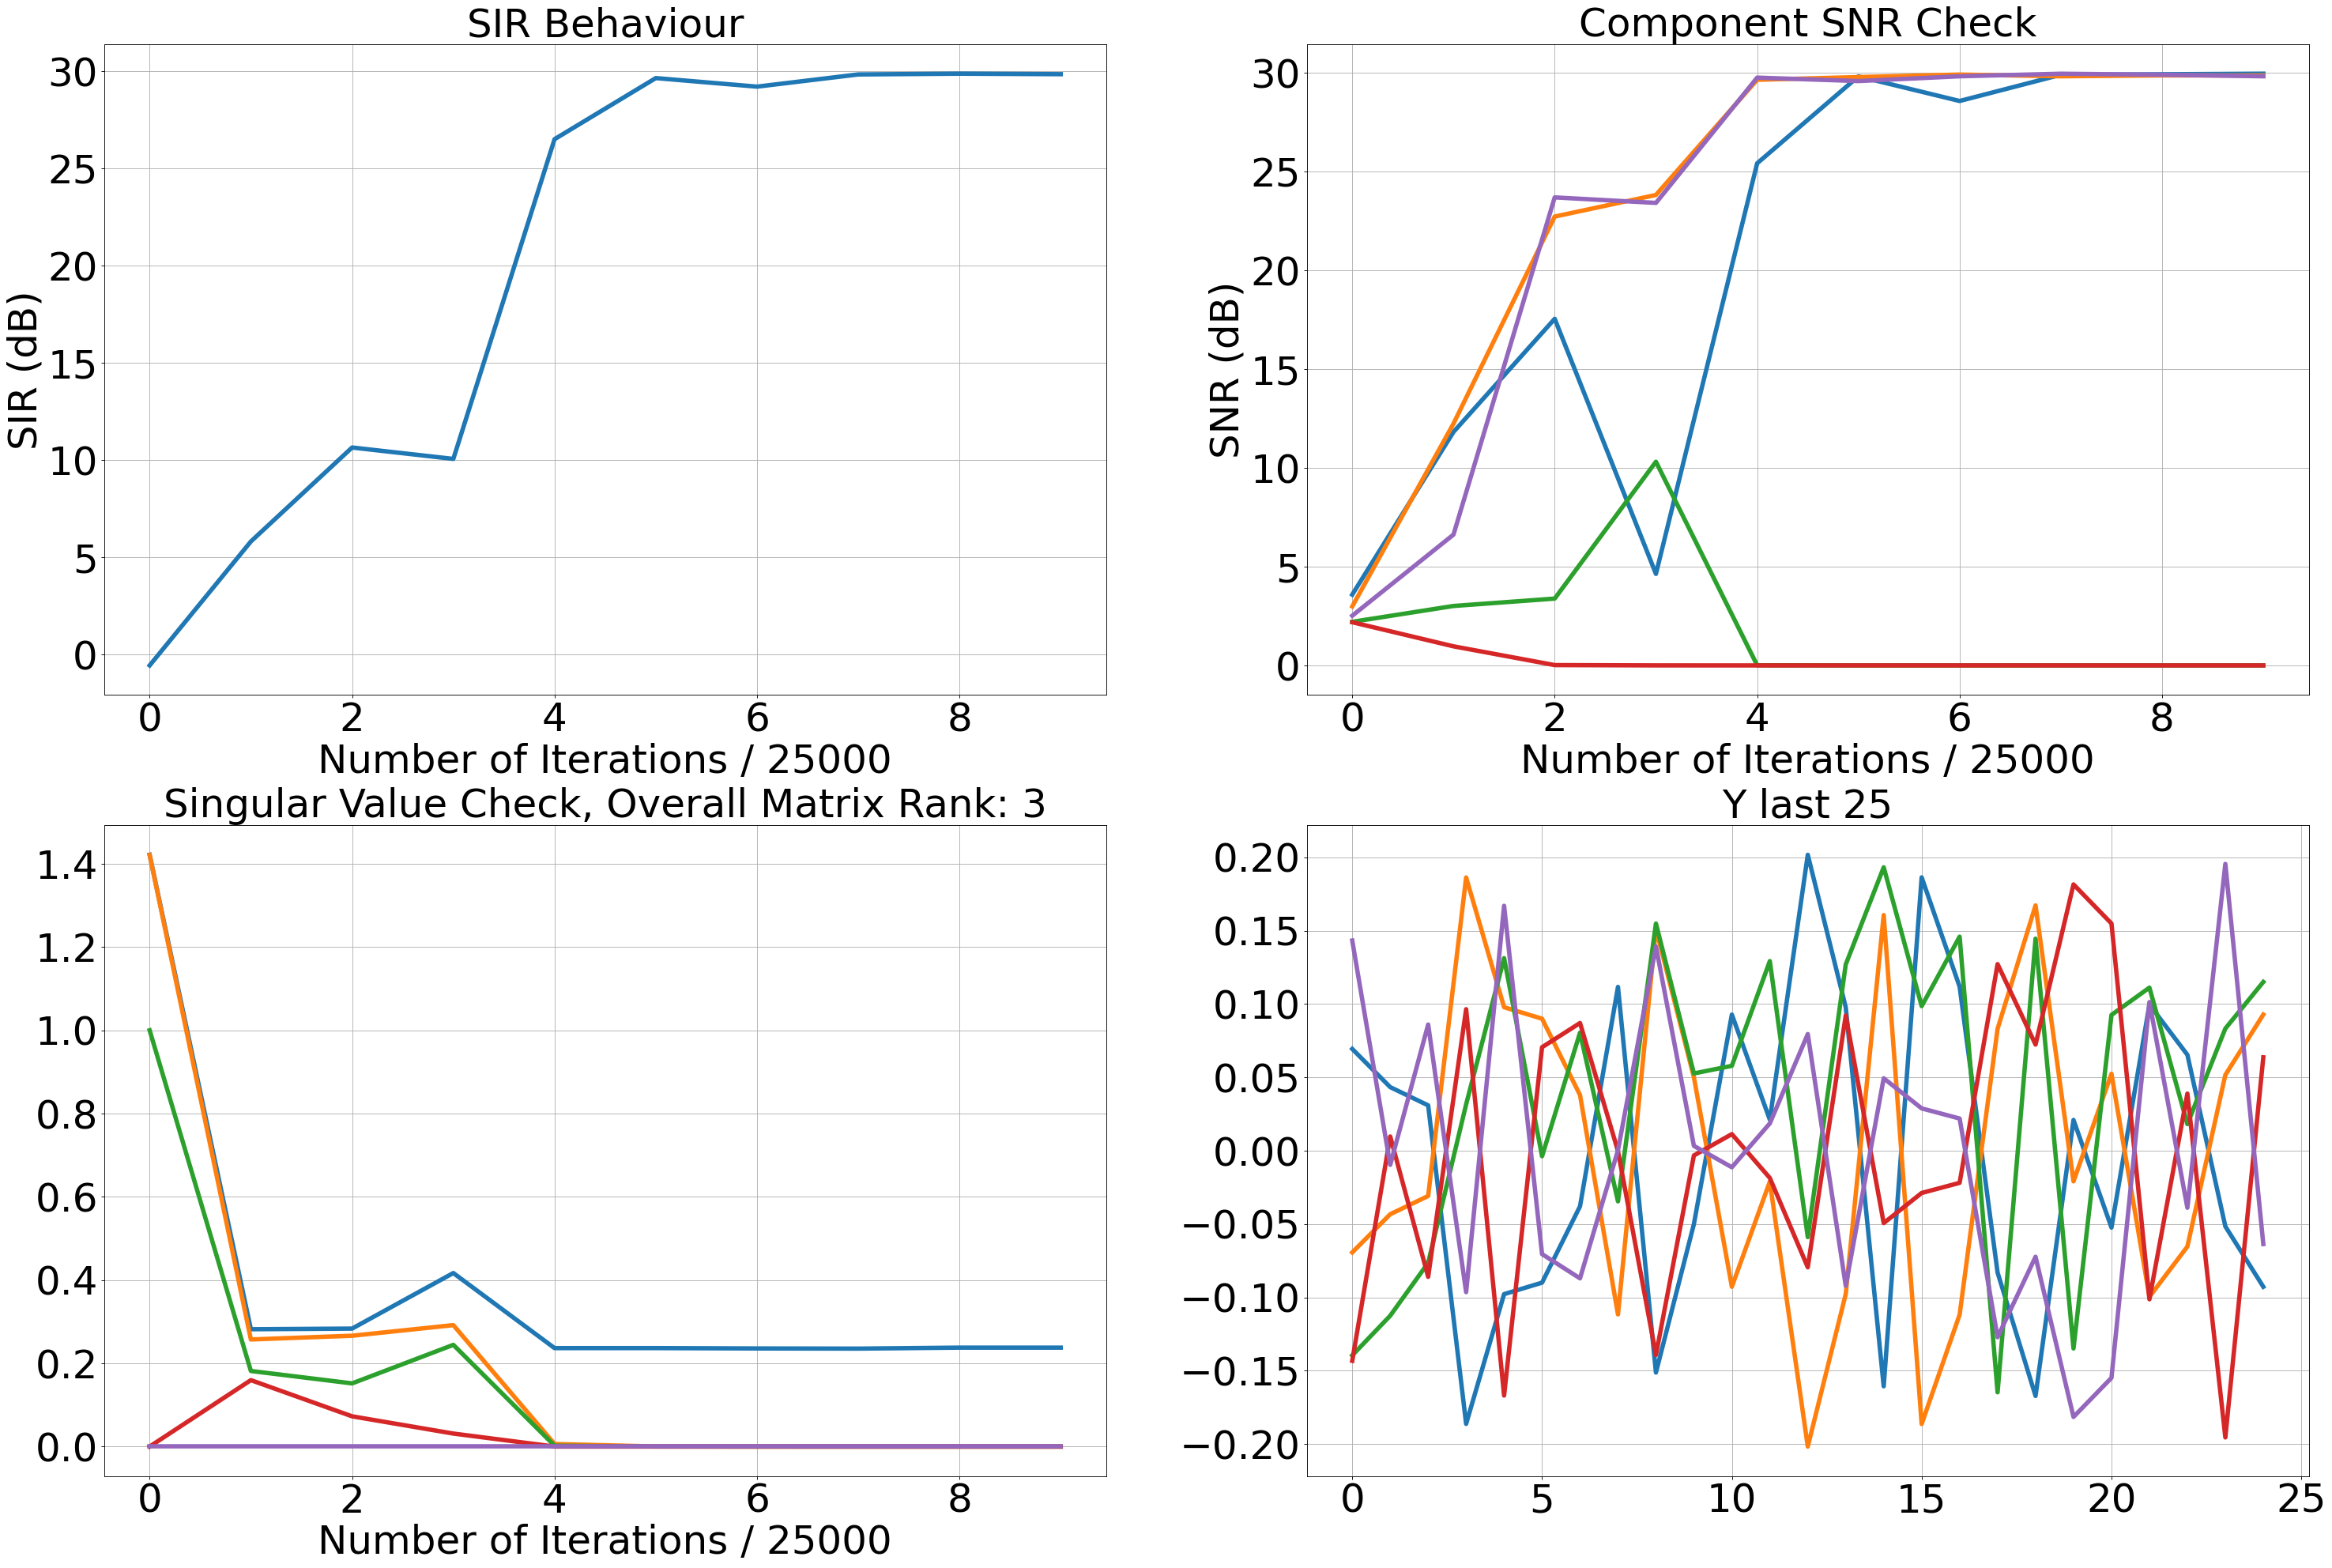

In [5]:
with Timer() as t:
    model.fit_batch_ica(
        X=X,
        n_epochs=1,
        neural_dynamic_iterations=1,
        plot_in_jupyter=True,
        neural_lr_start=0.1,
        neural_lr_stop=0.001,
        debug_iteration_point=debug_iteration_point,
        shuffle=True,
    )
print("Algorithm took %f sec." % (t.interval))

# Visualize SINR Convergence 

Final SINR: 29.86029780762049


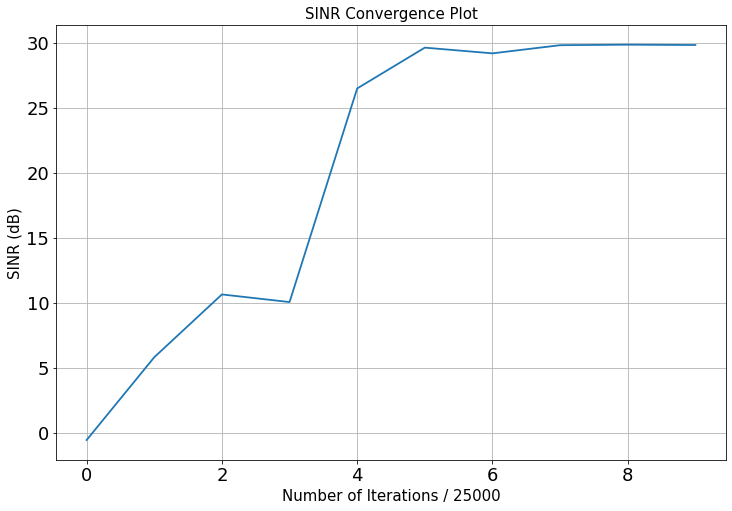

In [6]:
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
plot_convergence_plot(
    model.SIR_list,
    xlabel="Number of Iterations / {}".format(debug_iteration_point),
    ylabel="SINR (dB)",
    title="SINR Convergence Plot",
    colorcode=None,
    linewidth=1.8,
)

print("Final SINR: {}".format(np.array(model.SIR_list[-1])))

# Calculate Resulting Component SNRs and Overall SINR

In [7]:
Wf = model.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [nan nan nan nan nan]

Overall SINR : nan


# Vizualize Extracted Signals Compared to Original Sources

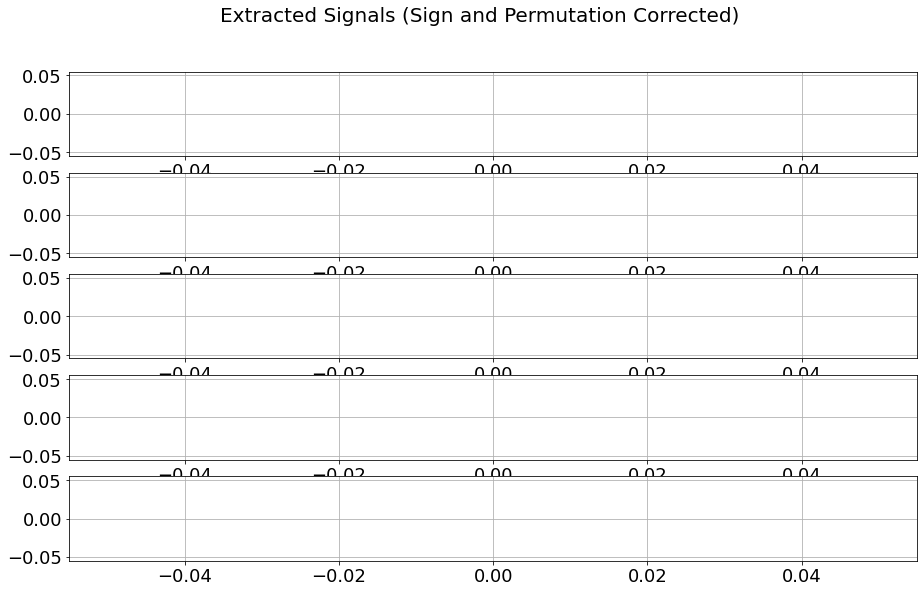

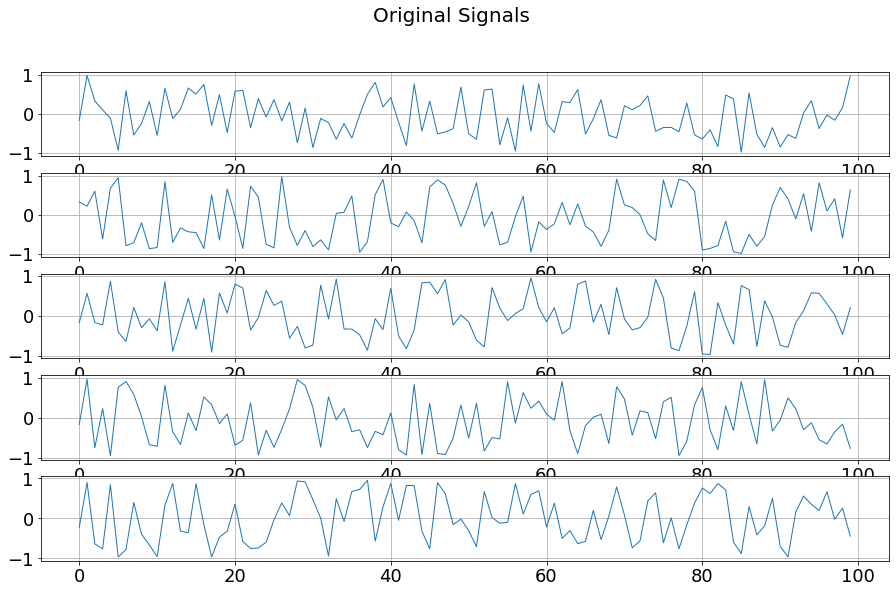

In [8]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)